<a href="https://colab.research.google.com/github/sashwinbwaj/DNLP-Disaster-Tweet-Predictions/blob/main/DNLP_Disaster_Tweet_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP to Predict Disaster Tweets

This project uses NLP to clean ~10000 tweets and encode it using various vectorizers such as Count/Tf-Idf & Hashing. The encoded matrix is used to predict if the tweet is about a disaster, using multiple classifiers. A ridge regression classifier is taken as a benchmark, resulting is ~80% accuracy. Naive Bayes classifier, one of the most popular algorithms used in NLP was also implemented with hyper-parameter tuning, resulting in enhanced accuracies in both the K-folds validation set & out-of-sample test set.  
We finally experimented with deep neural networks. A couple of recurrent layers using LSTMs were followed by a flattened MLP. The results were not an improvement to the traditional ML techniques, possibly due to the amount of data in the model. 

#### 1.0 Loading & Pre-processing (Dropping/ Missing value treatment)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
tweets_train = pd.read_csv("train.csv")
tweets_train = tweets_train.drop(columns = 'id')
tweets_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
tweets_train.shape[0]
tweets_train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [27]:
print('The median of the location is', tweets_train.location.value_counts().index[0])
print('The median of the keyword is', tweets_train.keyword.value_counts().index[0])

The median of the location is USA
The median of the keyword is fatalities


In [28]:
tweets_train['location'] = np.where(tweets_train['location'].isna(), 'USA', tweets_train['location'])
tweets_train['keyword'] = np.where(tweets_train['keyword'].isna(), 'fatalities', tweets_train['keyword'])

In [29]:
tweets_train.isnull().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [30]:
tweets_test = pd.read_csv("test.csv")
tweets_test = tweets_test.drop(columns = 'id')
tweets_test['location'] = np.where(tweets_test['location'].isna(), 'USA', tweets_test['location'])
tweets_test['keyword'] = np.where(tweets_test['keyword'].isna(), 'fatalities', tweets_test['keyword'])
tweets_train.isnull().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [31]:
tweets_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [32]:
tweets_train.query("target == 0").head()

,keyword,location,text,target
15,fatalities,USA,What's up man?,0
16,fatalities,USA,I love fruits,0
17,fatalities,USA,Summer is lovely,0
18,fatalities,USA,My car is so fast,0
19,fatalities,USA,What a goooooooaaaaaal!!!!!!,0


#### 1.1 EDA - Most common words represented in disaster tweets

In [35]:
# cleaning tweets taggeed as disasters to plot words with most frequencies
disaster_tweets = tweets_train.loc[tweets_train['target'] == 1,]
disaster_tweets['final_text'] = disaster_tweets.apply(lambda x: clean_tweets(x['text'], ' '), axis = 1)
word_corpus = []
disaster_tweets.head()
for i in range(0, disaster_tweets.shape[0]):
    words = disaster_tweets.iloc[i,4].split()
    for word in words:
        word_corpus.append(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Frequency')

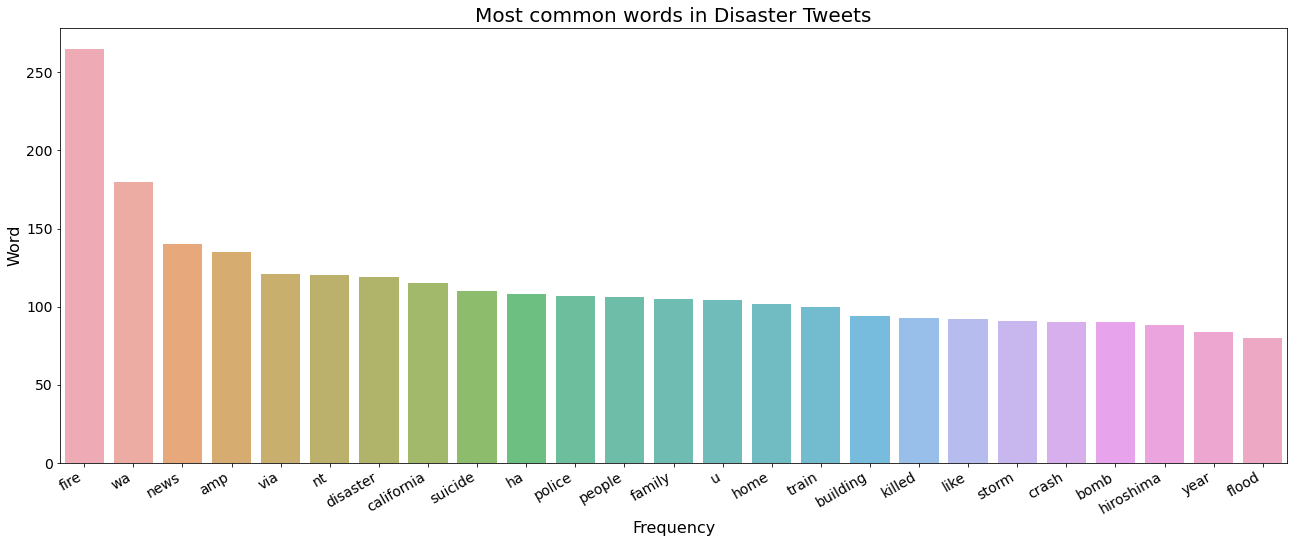

In [36]:
from collections import Counter
high_frequencies = pd.DataFrame(Counter(word_corpus).most_common(25), columns=['word', 'count'])

fig, ax = plt.subplots(figsize = (22,8))
ax = sns.barplot(data = high_frequencies, x = 'word', y = 'count', alpha = 0.8)
plt.xticks(ha = 'right', fontsize = 14, rotation = 30)
plt.yticks(fontsize = 14)
ax.set_title('Most common words in Disaster Tweets', fontsize = 20)
ax.set_ylabel('Word', fontsize = 16)
ax.set_xlabel('Frequency', fontsize = 16)

#### 1.3 Tweet cleaning using string methods & NLTK 

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
# Defining a function that takes in the text & keyword of the tweet to return a cleaned text which can input into vectorizer 
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
import re

punctuations_removal = str.maketrans('','', string.punctuation) # creating a mapping to remove punctuations
stops = stopwords.words('english') # creating a list of stop words in English

def clean_tweets(input_text, keyword):
    
    if type(input_text) == float:
        return ""
    # punctuations_removal = str.maketrans('','', string.punctuation) # creating a mapping to remove punctuations
    # stops = stopwords.words('english') # creating a list of stop words in English
    temp = input_text.lower() # converting to lowercase
    temp = temp = re.sub(r'http\S+', '', temp) #removing links
    keyword = str(keyword) # converting pandas to string
    
    tokens = word_tokenize(temp) # converting strings to list of word
    stripped_tokens = [words.translate(punctuations_removal) for words in tokens] # removing punctuations
    stripped_tokens = stripped_tokens # adding keyword to the list
    stripped_tokens = [word for word in stripped_tokens if word.isalpha()]# removing non-alphanumeric words 
    stripped_tokens = [lemmatizer.lemmatize(word) for word in stripped_tokens] # lemmatizing
    stripped_tokens = [word for word in stripped_tokens if word not in stops] # removing stop words  
    return ' '.join(stripped_tokens) # joining words to a text list

In [37]:
# applying the cleaner function on the dataset
tweets_train['final_text'] = tweets_train.apply(lambda x: clean_tweets(x['text'], x['keyword']), axis = 1)

In [38]:
# Splitting dataset into train & test sets
from sklearn.model_selection import train_test_split
X = tweets_train['final_text']
y = tweets_train['target']
X_train, X_test, y_train, y_test = train_test_split(tweets_train['final_text'], tweets_train['target'], test_size=0.25, random_state=0)
X_train.head()

5244    refugio oil spill may costlier bigger projecte...
4860    julian knight scvsupremecourt dismisses mass m...
6538    electricity cant stop scofield nigga survived ...
5175    meek mill begging nicki minaj let obliterate o...
5820    stock market crash summer ha sparked interest ...
Name: final_text, dtype: object

### 1.4 Text vectorization

Texts cannot be directly be input into the classification models. Vectorization methods are used to convert texts into numerical representations. There are a bunch of ways to vectorize strings:  
1. **Frequency based trainable methods**: These are used to convert the entire document into a corpus of words, which is used to represent unique words. The type of representation can be binary (1/0 if the word is in the sentence), count (number of times it appears) or even term frequency - inverse document frequency (can be thought of as a regualarized version which penalises words which appears frequently)
2. **Word embeddings** - Embeddings are a class of vectorization methods which represents words in a corpus in a k-dimensional feature space where similar words are placed closed to each other. While frequency based methods don't capture the relationships between words, embeddings does a good job in understanding the syntactic & semantic relationships between words.  

Some of the famous embedding systems include Skip-grams & CBOW in Word2Vec, GLove etc. In this project, we will use two encoder systems to convert the cleaned texts into numerical inputs for the classifer. A baseline model (Ridge-Classifier) is used to compare the efficiences of the encoders.

#### 1.4.1 Count vectorizer
This encoder creates a vocubulary based on the text corpus & encodes each tweet into a sparse matrix containing the frequency occurences of each word in the tweet

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
# creating the count vectorizer function
vectorizer = CountVectorizer()
# creating a vocabulary based on X-train texts
vectorizer.fit(X_train)
# fitting it on the train & test datasets
tweets_train_vectors = vectorizer.transform(X_train)
tweets_test_vectors = vectorizer.transform(X_test)

In [40]:
print(X_train[0])
print(tweets_train_vectors[0].toarray())

deed reason earthquake may allah forgive u
[[0 0 0 ... 0 0 0]]


In [41]:
# Each sentence in the original array was converted to a dense matrix containing the count of those words measured in the word corpus
print(X_train.shape)
print(tweets_train_vectors.todense().shape)

(5709,)
(5709, 12303)


In [42]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = RidgeClassifier()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Ridge regression classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

Accuracy on K-folds validation on train set: 0.773 (0.016)
Accuracy of Ridge regression classifier on test set: 0.79


#### 1.4.2 Term Frequency - Inverse Document Frequency Vectorizer

To penalize the occurence of commonly used terms, the Tf-Idf vectorizer calculates word frequencies in a tweet & downsizes it based on the number of tweets containing the same word in the entire document corpus

In [43]:
# creating the Tf-IDF vectorizer function
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 15000)
# creating a vocabulary based on X-train texts
vectorizer.fit(X_train)
# fitting it on the train & test datasets
tweets_train_vectors = vectorizer.transform(X_train).toarray()
tweets_test_vectors = vectorizer.transform(X_test).toarray()

vocubulary = vectorizer.vocabulary_
print(X_train.shape)
print(tweets_train_vectors.shape)
print(y_train.shape)

(5709,)
(5709, 12303)
(5709,)


In [44]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = RidgeClassifier()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Ridge regression classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy on K-folds validation on train set: 0.794 (0.017)
Accuracy of Ridge regression classifier on test set: 0.80


### 2.1 Naive Bayes Classifier

In a small dataset such as ours, Naive Bayes might work well since it assumes that the words in the tweet are now independent of each other & we can use the probabilities of each word in the entire corpus to determine the conditional probability of a tweet being about a disaster.  
For words that never appear in the corpus, NB uses Laplace smoother (adding 1 to the frequency of each term & adding n (unique words) to the denominator) to avoid probability to plummet to zero.  

In [45]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = MultinomialNB()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

Accuracy on K-folds validation on train set: 0.799 (0.017)
Accuracy of Naive Bayes classifier on test set: 0.80


#### Fitting the data into the testset & submitting results to Kaggle

The test dataset does not contain the target class, so we will fit the Naive Bayes model to the test set & submit the predictions. 

In [46]:
# applying the cleaner function on the dataset
tweets_test['final_text'] = tweets_test.apply(lambda x: clean_tweets(x['text'], x['keyword']), axis = 1)
outsample_X = tweets_test['final_text']
outsample_vectors = vectorizer.transform(outsample_X)
tweets_test['target'] = clf.predict(outsample_vectors)

In this project, we used NLTK & string methods to clean tweets. The cleaned tweets were vectorized & tested with two models : Ridge & Naive Bayes classifier.  
Owing to the small size & content constraints, the NB classifier worked out slightly better than the baseline model. We can explore more sophisticated methods such as SVM, Neural Networks etc to improve performance. 

### 3.1 Training a Recurrent Neural Network
Here, we have experimented with a couple of layers of LSTMS (Long Short Term Memory cells) for our text classification exercise. LSTMs are an extension to the traditional recurrent neural networks (RNNs) which contain a bunch of gates to decide the relative importance of information being passed at different stages in the process.   
Each timestep can be considered as a word in a sentence being passed into the model, so the model understands the important features from the previous words of the sentence, which also considers the importance in the particular word being fed as an input.  
This helps in overcoming one of the biggest flaws of the traditional RNN - long term dependencies. By maintaining a hidden state, the problem of vanishing gradients is taken care of in LSTMs. 

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=None, 
                     filters='!"#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = True, split = ' ')
# train the tokenizer on train data
tokenizer.fit_on_texts(X_train)

# convert train into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)


# padding the sentences
max_length = 20
padded_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')
print(pd.DataFrame(padded_test))
padded_train.shape

        0     1     2     3     4     5    6   ...  13  14    15  16  17  18  19
0      471    42   149    36    44   971  337  ...   0   0     0   0   0   0   0
1       13   145   482   234    19   540  479  ...   0   0     0   0   0   0   0
2      426   133   466  3743   699     0    0  ...   0   0     0   0   0   0   0
3      168    65   791  1241    37   330    6  ...   0   0     0   0   0   0   0
4      451    49    36    78  1288  1455    0  ...   0   0     0   0   0   0   0
...    ...   ...   ...   ...   ...   ...  ...  ...  ..  ..   ...  ..  ..  ..  ..
1899   855   380     0     0     0     0    0  ...   0   0     0   0   0   0   0
1900  1359  4254  6510    37  1051   209   13  ...  43   8  1771   0   0   0   0
1901   131   906   667   458   156    82   66  ...   0   0     0   0   0   0   0
1902   216   301   728   763   140   216    6  ...   0   0     0   0   0   0   0
1903    84   475    75  2625    88   230  290  ...   0   0     0   0   0   0   0

[1904 rows x 20 columns]


(5709, 20)

In [48]:
from tensorflow.keras.layers import Embedding, LSTM, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras import callbacks

final_train = padded_train[:, :, None] 
final_test = padded_test[:, :, None] 

# final_train = tweets_train_vectors[:, :, None] 
# final_test = tweets_test_vectors[:, :, None] 

idx_word = tokenizer.index_word
num_words = len(idx_word) + 1
input_shape = final_train.shape


model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 100, trainable = True, embeddings_initializer='uniform', input_length = max_length))
# model.add(Flatten())
model.add(LSTM(units=64, input_shape = input_shape, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1))
model.add(LSTM(units=32, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

model.fit(final_train, y_train, epochs=100, verbose=1, validation_data = (final_test, y_test) ,
              callbacks = [callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1232300   
                                                                 
 lstm (LSTM)                 (None, 20, 64)            42240     
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dense (Dense)               (None, 20, 100)           3300      
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 20, 1)             101       
                                                                 
Total params: 1,290,357
Trainable params: 1,290,357
Non-

In [49]:
model.evaluate(final_test, y_test)

60/60 [==============================] - 1s 17ms/step - loss: 2.2955 - accuracy: 0.7444


[2.2954633235931396, 0.7443802356719971]